In [1]:
import os
import cv2
import random
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
if torch.cuda.is_available() == True:
       device = 'cuda:0'
       print('현재 가상환경 GPU 사용 가능 상태')
else:
       device = 'cpu'
       print('GPU 사용 불가능 상태')

GPU 사용 불가능 상태


In [3]:
def seed_everything(seed: int = 24):
       random.seed(seed)
       np.random.seed(seed)
       # torch.cuda.manual_seed(seed)
       # torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
tot_actions = 5
actions_name = 'backward', 'sit', 'slide', 'swing', 'walk'
min_data_len = 45

In [5]:
actions_csv_dir = '../csv_1031/'
dataset = []

label_mapping = {'backward': 0,
                 'sit': 1,
                 'slide': 2,
                 'swing': 3,
                 'walk' : 4
                 }

def map_action_to_label(csv_name):
       for action, label in label_mapping.items():
              if action in csv_name.split('_')[0]:
                     return label
       return -1


for action_csv in os.listdir(actions_csv_dir):
       action_df = pd.read_csv(os.path.join(actions_csv_dir, action_csv))
       
       label = map_action_to_label(action_csv)
       if label != -1:
              for idx in range(0, len(action_df), int(min_data_len / 2)):
                     seq_df = action_df[idx: idx + min_data_len] #길이만큼 데이터 자른 것(즉 length 만큼의 프레임)
                     if len(seq_df) == min_data_len: # 딱 length에 개수 맞춰서 끊어서 넣으려고
                            dataset.append({'key': label, 'value': seq_df}) # key에 slide, value에는 묶음 프레임 만큼이 담기겠네
       #최종적으로 dataset에는 행동별로 dictionary 가 만들어져 들어간다.

In [6]:
print(dataset[0]['value'].columns) # z축 까지 99 (33 * 3)차원

Index(['Nose_x', 'Nose_y', 'Nose_z', 'LEye_in_x', 'LEye_in_y', 'LEye_in_z',
       'LEye_x', 'LEye_y', 'LEye_z', 'LEye_out_x', 'LEye_out_y', 'LEye_out_z',
       'REye_in_x', 'REye_in_y', 'REye_in_z', 'REye_x', 'REye_y', 'REye_z',
       'REye_out_x', 'REye_out_y', 'REye_out_z', 'LEar_x', 'LEar_y', 'LEar_z',
       'REar_x', 'REar_y', 'REar_z', 'LMouth_x', 'LMouth_y', 'LMouth_z',
       'RMouth_x', 'RMouth_y', 'RMouth_z', 'LShoulder_x', 'LShoulder_y',
       'LShoulder_z', 'RShoulder_x', 'RShoulder_y', 'RShoulder_z', 'LElbow_x',
       'LElbow_y', 'LElbow_z', 'RElbow_x', 'RElbow_y', 'RElbow_z', 'LWrist_x',
       'LWrist_y', 'LWrist_z', 'RWrist_x', 'RWrist_y', 'RWrist_z', 'LPinky_x',
       'LPinky_y', 'LPinky_z', 'RPinky_x', 'RPinky_y', 'RPinky_z', 'LIndex_x',
       'LIndex_y', 'LIndex_z', 'RIndex_x', 'RIndex_y', 'RIndex_z', 'LThumb_x',
       'LThumb_y', 'LThumb_z', 'RThumb_x', 'RThumb_y', 'RThumb_z', 'LHip_x',
       'LHip_y', 'LHip_z', 'RHip_x', 'RHip_y', 'RHip_z', 'LKnee_x', 'LKn

In [7]:
class MyDataset(Dataset):
       def __init__(self, dataset): #모든 행동을 통합한 df가 들어가야함
              self.x = []
              self.y = []
              for dic in dataset:
                     self.y.append(dic['key']) #key 값에는 actions 들어감
                     self.x.append(dic['value']) #action마다의 data 들어감

       def __getitem__(self, index): #index는 행동의 index
              data = self.x[index] # x에는 꺼내 쓸 (행동마다 45개 묶음프레임)의 데이터
              label = self.y[index]
              return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

       def __len__(self):
              return len(self.x)


In [8]:
train_test_val_ratio = [0.8, 0.1, 0.1]
print(len(dataset))
train_len = int(len(dataset) * train_test_val_ratio[0])
val_len = int(len(dataset) * train_test_val_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

664
531, 66, 67


In [21]:
CFG = {'batch_size': 32,
       'learning_rate': 1e-4,
       'seed':24,
       'epochs': 100   
}

In [22]:
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=CFG['batch_size'])
val_loader = DataLoader(valid_data, batch_size=CFG['batch_size'])
test_loader = DataLoader(test_data, batch_size=CFG['batch_size'])

In [23]:
class Model(nn.Module):
       def __init__(self):
              super(Model, self).__init__()
              self.lstm1 = nn.LSTM(input_size=99, hidden_size=128, num_layers=1, batch_first=True) #input은  45 * 3(x, y z)
              self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
              self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
              self.dropout1 = nn.Dropout(0, 1)
              self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
              self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
              self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
              self.dropout2 = nn.Dropout(0, 1)
              self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
              self.fc = nn.Linear(32, 5) #분류할 클래스 5가지

       def forward(self, x):
              x, _ = self.lstm1(x)
              x, _ = self.lstm2(x)
              x, _ = self.lstm3(x)
              x = self.dropout1(x)
              x, _ = self.lstm4(x)
              x, _ = self.lstm5(x)
              x, _ = self.lstm6(x)
              x = self.dropout2(x)
              x, _ = self.lstm7(x)
              x = self.fc(x[:, -1, :])
              return x

In [24]:
# for data, label in test_loader:
#        print('data:', len(data)) # 배치만큼 출력하니까 'data: 8.. '
d = []
l = []
for data, label in test_loader:
       d.append(data)
       l.append(label)
print(d[0].shape) # 8개 잡은 배치, 45개 seqence 길이, 99 차원

torch.Size([32, 45, 99])


Epoch: 0 - Train Loss: 1.585879 - Train Acc: 0.061920 - Valid Loss: 1.542988 - Valid Acc: 0.031250
Epoch: 1 - Train Loss: 1.497454 - Train Acc: 0.483166 - Valid Loss: 1.303897 - Valid Acc: 0.718750
Epoch: 2 - Train Loss: 1.376991 - Train Acc: 0.523607 - Valid Loss: 1.157289 - Valid Acc: 0.718750
Epoch: 3 - Train Loss: 1.318863 - Train Acc: 0.523607 - Valid Loss: 1.071492 - Valid Acc: 0.718750
Epoch: 4 - Train Loss: 1.290802 - Train Acc: 0.523607 - Valid Loss: 1.032375 - Valid Acc: 0.718750
Epoch: 5 - Train Loss: 1.277926 - Train Acc: 0.523607 - Valid Loss: 1.018920 - Valid Acc: 0.718750
Epoch: 6 - Train Loss: 1.270365 - Train Acc: 0.523607 - Valid Loss: 1.014537 - Valid Acc: 0.718750
Epoch: 7 - Train Loss: 1.264929 - Train Acc: 0.523607 - Valid Loss: 1.013684 - Valid Acc: 0.718750
Epoch: 8 - Train Loss: 1.260996 - Train Acc: 0.523607 - Valid Loss: 1.013621 - Valid Acc: 0.718750
Epoch: 9 - Train Loss: 1.258174 - Train Acc: 0.523607 - Valid Loss: 1.013395 - Valid Acc: 0.718750
Epoch: 10 

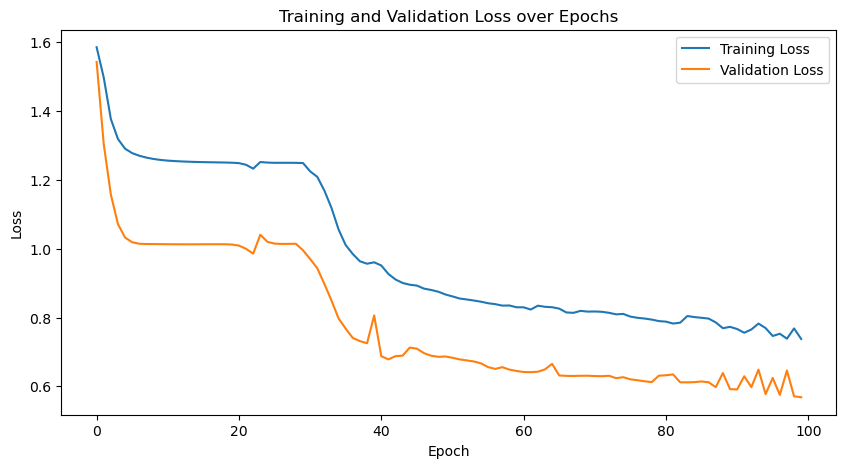

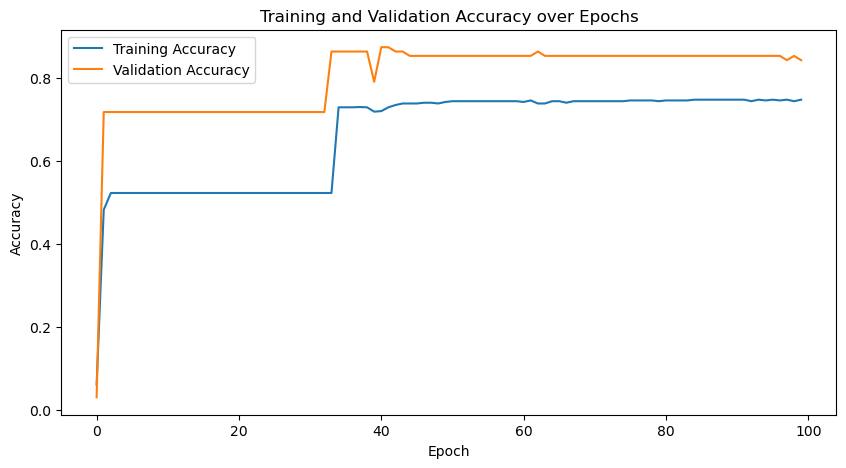

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


num_epochs = CFG['epochs']
best_models = [] 

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['learning_rate'])
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.9)  # learning rate scheduler 로 학습률 주기적 감소

val_acc_max = 0.75
val_loss_min = 0.25

# Lists to store training and validation metrics for each epoch
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
       train_loss_list = []
       val_loss_list = []
       train_acc_list = []
       val_acc_list = []

       # 모델 학습
       for i, (images, targets) in enumerate(train_loader):
              model.train()
              optimizer.zero_grad()
              outputs = model(images)

              targets = targets.long()
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()

              train_loss_list.append(loss.item())

              preds = torch.argmax(outputs, dim=1)
              batch_acc = (preds == targets).float().mean()
              train_acc_list.append(batch_acc.item())

              if (i + 1) % 20 == 0:
                     print(f'Epoch: {epoch} - Batch: {i+1}/{len(train_loader)} - Loss: {loss:.6f}')

       train_loss = np.mean(train_loss_list)
       train_acc = np.mean(train_acc_list)

       # 모델 검증
       for i, (images, targets) in enumerate(val_loader):
              model.eval()
              with torch.no_grad():
                     outputs = model(images)
                     targets = targets.long()
                     val_loss = criterion(outputs, targets)
                     preds = torch.argmax(outputs, dim=1)
                     batch_acc = (preds == targets).float().mean()
                     val_loss_list.append(val_loss.item())
                     val_acc_list.append(batch_acc.item())

       val_loss = np.mean(val_loss_list)
       val_acc = np.mean(val_acc_list)

       # Append metrics to the history lists
       train_loss_history.append(train_loss)
       val_loss_history.append(val_loss)
       train_acc_history.append(train_acc)
       val_acc_history.append(val_acc)

       print(f'Epoch: {epoch} - Train Loss: {train_loss:.6f} - Train Acc: {train_acc:.6f} - Valid Loss: {val_loss:.6f} - Valid Acc: {val_acc:.6f}')

       # val에서의 정확도 기준 모델 저장
       if val_acc_max < val_acc:
              val_acc_max = val_acc
              best_models.append(model)
              print('Model saved, model val acc: ', val_acc)

       # 검증 손실이 최소일 때 모델 저장
       if val_loss_min > val_loss:
              val_loss_min = val_loss
              torch.save(model.state_dict(), 'best_model.pth')

       lr_scheduler.step()

print('Train finished, best_models size: ', len(best_models))

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()


In [26]:
# 정확도 검증
with torch.no_grad():
       test_loss, test_acc = epoch(test_loader, mode='test')
       test_acc = round(test_acc, 4)
       test_loss = round(test_loss, 4)
       print('Test Acc.: {}'.format(test_acc))
       print('Test Loss: {}'.format(test_loss))


TypeError: 'int' object is not callable

In [ ]:
early_stopping = EarlyStopping(patience = 30, verbose = True)

num_epochs = 200
learning_rate = 1e-3
input_size = 6
hidden_size = 512
num_layers = 2

num_classes = 61
# quantile = 0.3


train_losses = []
valid_losses = []


lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

lstm.apply(init_weights)

# criterion = quantile_loss    # mean-squared error for regression
criterion = torch.nn.NLLLoss()   # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay= 1e-5)
criterion = criterion.cuda()

m = nn.Softmax(dim = 1)

# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate,momentum=0.9)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience= 60, 
#           factor =0.1 ,min_lr=1e-6, eps=1e-08)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,700,900,1000], gamma=0.1)

for epoch in progress_bar(range(num_epochs+1)):


       # train

       losses = []
       for i, (input, target) in enumerate(train_dataloader):

              lstm.train()
              outputs = lstm(input.to(device))
              optimizer.zero_grad()


              # print(f'target shape: {target.shape}')
              # print(f'outputs shape: {outputs.shape}')
              # print(outputs[0])
              # print(target[0])
              loss = criterion(m(outputs), target.type(torch.long).to(device))
              loss.backward()

              # scheduler.step()
              # torch.nn.utils.clip_grad_norm_(lstm.parameters(), 10)

              optimizer.step()
              losses.append(loss.item())

       train_losses.append(np.mean(np.array(losses)))

       losses = []
       for i, (input, target) in enumerate(train_dataloader):

              lstm.eval()
              valid = lstm(input.to(device))

              #inverse
              # valid = torch.from_numpy(scaler.inverse_transform(valid.cpu().detach().numpy()))

              vall_loss = criterion(m(valid), target.type(torch.long).to(device))
              # scheduler.step(vall_loss)
              losses.append(vall_loss.item())

       valid_losses.append(np.mean(np.array(losses)))



       if epoch % 10 == 0:
              # print(criterion1(outputs, y_train.to(device),quantile))

              print("Epoch: %d, loss: %1.5f valid loss:  %1.5f lr: %1.5f " %(epoch, train_losses[-1],valid_losses[-1],
                                                                             optimizer.param_groups[0]["lr"]))

       torch.save(lstm.state_dict(), SAVEPATH+'model_weight.pth')
       # model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))

       # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
       # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
       early_stopping(round(valid_losses[-1],5), lstm)

       if early_stopping.early_stop:
              print("Epoch: %d, loss: %1.5f valid loss:  %1.5f lr: %1.5f " %(epoch, train_losses[-1],valid_losses[-1],
                                                                             optimizer.param_groups[0]["lr"]))
              break